# Synapse Examples
Examples of different ways to use synaptic connections between fronts derived from ``SynFront``:
- Grow a simple neuron together with straight axons that make branches to synapse onto the neuron: [Simple_synapses](#Simple_synapses)
- More axons and count the number of synapses on each branch of the neuron: [Count_synapses](#Count_synapses)
- Same as previous but now the number of synapses is used to retract branches with few synapses: [Retract_few_synapses](#Retract_few_synapses)
- Axons have variable firing rates, synapses do leaky signal integration of synaptic input: [Integrated_variable_input](#Integrated_variable_input)
- Same model but fronts are now colored for amplitude of leaky signal: [Colored_signal](#Colored_signal)
- Combination of two previous examples: branches with low summed integrated synaptic input are retracted: [Retract_low_input](#Retract_low_input)

## Simple_synapses
Grow a simple neuron together with straight axons that make branches to synapse onto the neuron. Synapses are only structural: they are not used in the simulation. This simple script will be elaborated in following ones.   
Axons use ``is_status1()`` to distinguish between main (True) and branches (False) and use two additional attributes: a c_short *prev_branch* as a counter to create distance between side branches from main and an ID *goalID* to store the front that the branch tries to make a synapse with.

<IPython.core.display.Javascript object>


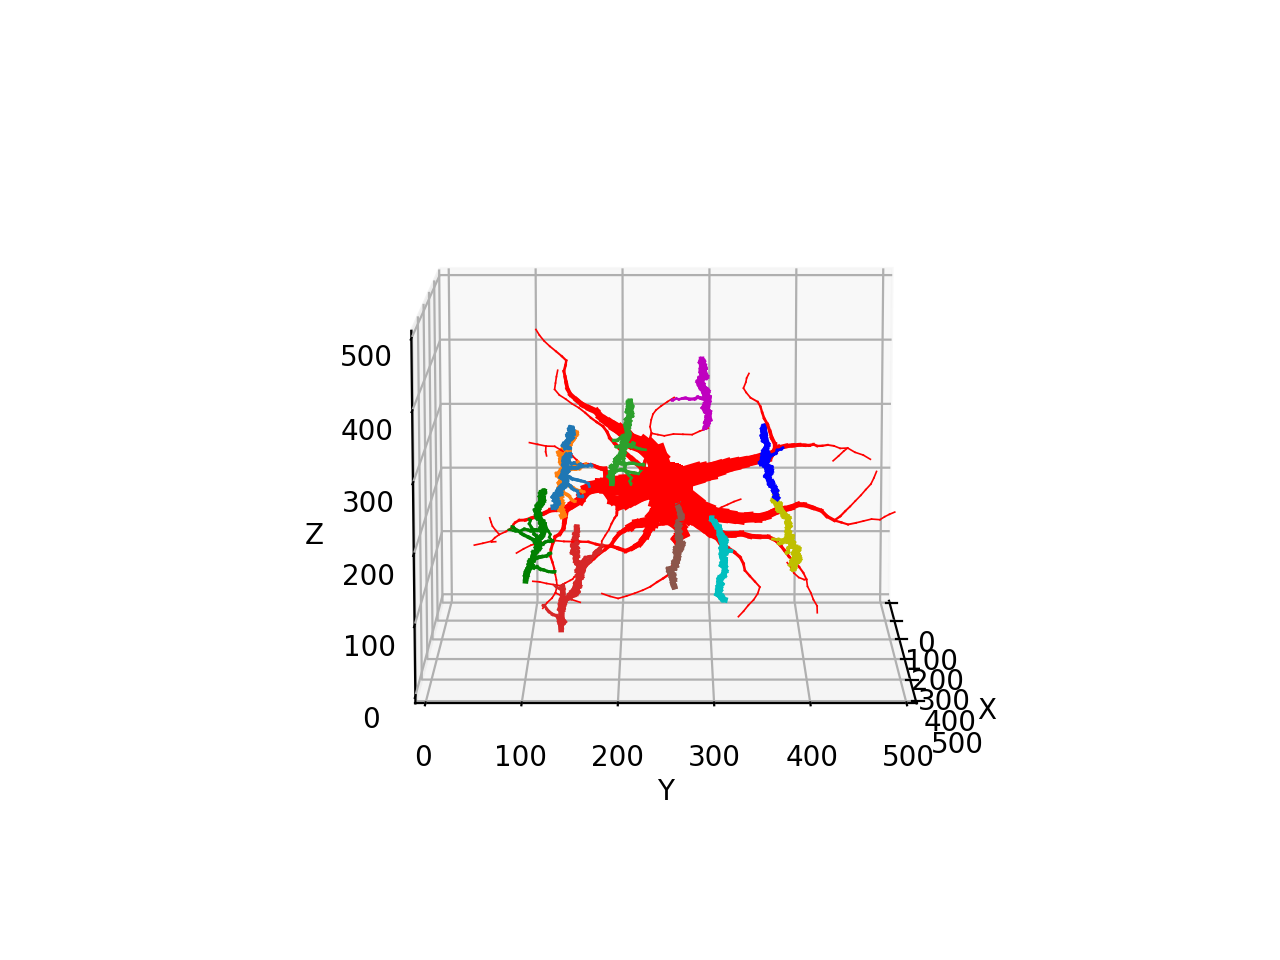

cycle 35 : axon_3_ makes a synapse on 8095
cycle 35 : axon_8_ makes a synapse on 12091
cyclecycle  3636  ::  axon_2_axon_7_  makes a synapse onmakes a synapse on  160884074

cycle 37 : axon_9_ makes a synapse on 16040
cycle 41 : axon_7_ makes a synapse on 16111
cycle43  : axon_10_ makes a synapse on 4060
cycle 44 : axon_4_ makes a synapse on 16045
cyclecycle  4545  ::  cycleaxon_8_axon_7_   45makes a synapse onmakes a synapse on   :1208912071 

axon_10_ makes a synapse on 12039
cycle   47 :axon_9_makes a synapse on 8037
cycle 50 : axon_3_ makes a synapse on 12063
cycle 53 : axon_6_ makes a synapse on 12040
cycle 54 : axon_9_ makes a synapse on 12003
cycle 55 : axon_7_ makes a synapse on 16086
cycle 55 : axon_9_ makes a synapse on 4017
cycle 56 : axon_6_ makes a synapse on 12044
cycle  57 : axon_2_makes a synapse on 4080
cycle 58 : axon_7_ makes a synapse on 16065
cycle 61 : axon_7_ makes a synapse on 8069
cycle cycle62  :62  :axon_2_  axon_3_makes a synapse on  4075makes a synapse on 


In [7]:
%matplotlib notebook 

from neurodevsim.simulator import *
import numpy as np

# The postsynaptic neuron
class SimpleNeuronFront(SynFront):
    
    def manage_front(self,constellation):
        if self.swc_type == 1: # this is the soma
            points = self.unit_branching_sample(16)  # generate vectors
            num_dend = 0 # count number of dendrites
            for p in points: # make 8 dendrites
                new_pos = self.orig + p * (10. + self.radius) # compute position of dendrite end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=4.,swc_type=3) # make a new front
                    num_dend += 1
                    if num_dend == 8: # enough dendrites made
                        # make soma inactive: stops growing -> will not call this method again
                        self.disable(constellation)
                        return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            print ("Warning: less than 8 dendrites made for",self.get_neuron_name(constellation),num_dend)
            # make soma inactive: stops growing -> will not call this method again
            self.disable(constellation)
        else:
            if self.path_length >= 300:
                self.disable(constellation) # terminus: stop growing
                return
            bif_prob = 0.30 / (self.order*3)
            if self.order > 4 :
                bif_prob = 0.03
            if np.random.random() > bif_prob: # continue a front
                # taper radius
                rad = self.taper(0.9)
                count = 0 # counts number of add_child trials
                while count < 10:
                    # random component along current heading
                    extension = self.unit_heading_sample(width=20)
                    new_pos = self.end + extension * 10. # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        # make front inactive: stops growing -> will not call this method again
                        self.disable(constellation)
                        return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
                if (constellation.cycle - self.birth) > 2: # this was second failed attempt:
                    self.disable(constellation) # stop trying
            else: # branch a front: generate two child fronts, or terminate
                points = self.unit_branching_sample(5) # generate more points than needed
                rad = self.taper(0.7) # strongly taper radius
                num_dend = 0 # count number of dendrite branches
                for p in points: # make 2 branches
                    new_pos = self.end + p * 10.  # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        num_dend += 1
                        if num_dend == 2: # enough dendrites made
                            # make front inactive: stops growing -> will not call this method again
                            self.disable(constellation)
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                if self.num_children > 0: # single child made -> make front inactive
                    self.disable(constellation)

# Axons growing from left to right and trying to make synapses
class AxonFront(SynFront):
    # extra attributes initalized to False and 0, updated in manage_front
    _fields_ = Front._fields_ + [('goalID', ID),('next_branch',c_short)]
    # status1 is used to flag fronts on the main branch of the axon

    # Main branch grows towards left, side branches grow towards a synapse site
    def manage_front(self,constellation):
        if constellation.cycle == 1: # first axon, main not initialized
            self.set_status1() # mark as main branch
        if self.is_status1(): # continuation of main branch growing leftward
            count = 0 # counts number of add_child trials
            new_front = None
            while count < 10:
                # random component along current heading
                extension = Point(6.,0.,0.) + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos) # make a new front
                    # self stays active in case of branching
                    new_front.set_status1() # mark as main branch
                    new_front.next_branch = max(0, self.next_branch - 1)
                    break # made a front
                except (CollisionError, GridCompetitionError, InsideParentError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
                except (VolumeError):
                    # growing outside of volume -> stop
                    self.disable(constellation)
                    return # completed this call
            if not new_front: # add_child failed
                self.disable(constellation)
                return # completed this call
            # check for nearby fronts
            targets = self.get_fronts(constellation,what='name',name="simple_neuron",max_distance=50.)
            no_branch = True
            for t in targets: # list of (front,distance), ordered by increasing distance
                goal = t[0]
                if goal.swc_type == 1: # do not synapse on soma
                    continue
                # check whether target front already has a synapse
                if goal.has_synapse():
                    continue
                distance = t[1]
                if distance < 1.: # close enough for a new synapse without branching
                    print ("cycle",constellation.cycle,":",self.get_neuron_name(constellation),"makes a synapse on",goal._fid,goal._yid)
                    try:
                        self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                        self.disable(constellation) # no further growth of main
                        return # done, no branching
                    except (SynapseError) as error:
                        print (error)
                elif self.next_branch == 0: # make a branch
                    self.goalID = goal.get_id()
                    new_front.next_branch = 5
                    rad = self.taper(0.7)
                    no_branch = False
                    break
            if no_branch:
                self.disable(constellation) # no further growth of main
                return # done, no branching
        else: # continuation of a branch
            goal = constellation.front_by_id(self.goalID)
            if goal.has_synapse(): # goal has been taken by other branch
                # start retraction of the branch, front by front
                parent = self.get_parent(constellation)
                if not parent.is_status1(): # branch front 
                    parent.enable(constellation) # make active so that it retracts also
                self.retract(constellation)
                return
            rad = self.taper(0.95)
        # grow or continue a side branch (can be initiation of first side front from main)
        direction = goal.surface_point_to(self.end) - self.end
        n_direction = direction.norm()
        distance = direction.length()
        if distance < 1.: # close enough for a new synapse
            print ("cycle",constellation.cycle,":",self.get_neuron_name(constellation),"makes a synapse on",goal._fid)
            try:
                self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
            except (SynapseError) as error:
                print (error)
            self.disable(constellation) # terminate growth of this axon (main) branch
            return # done, no branching
        else: # grow nearer towards front
            count = 0 # counts number of add_child trials
            while count < 10:
                if distance < 6.: # grow very close to surface of front
                    extension = n_direction * ((distance - 1.) * 0.9) + unit_sample_on_sphere()
                else: # grow front in direction of goal with some noise
                    extension = n_direction * 5. + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                    new_front.goalID = self.goalID
                    self.disable(constellation) # terminate growth of this axon (main) branch 
                    return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/synapses.db"
    sim_volume = [[0., 0., 0.], [500., 500., 500.]]
    neuron_types = [SimpleNeuronFront,AxonFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,max_synapse=400,verbose=0,plot=True,soma_black=False,elev=10,azim=0)


    # make simple neuron
    admin.add_neurons(SimpleNeuronFront,"simple_neuron",1,[[300.0,250.0,250.0],[300.,250.,250.]],30.)

    # make 10 axons: these grow 'from outside' into the volume
    admin.add_neurons(AxonFront,"axon",10,[[1,100,100],[1,400,400]],1.,axon=[5.0,0.,0.])
        
    # run the simulation
    admin.simulation_loop(90)

    # clean up
    admin.destruction()

## Count_synapses
Reports number of synapses on each branch at the end of simulation.  
To do this the *SimpleNeuronFront* soma remains active but non-growing after it makes the dendritic roots. In cycle 90 the soma then calls ``get_branch_synapses`` for each of its children. No changes to *AxonFront* but its print statement is disabled.

<IPython.core.display.Javascript object>


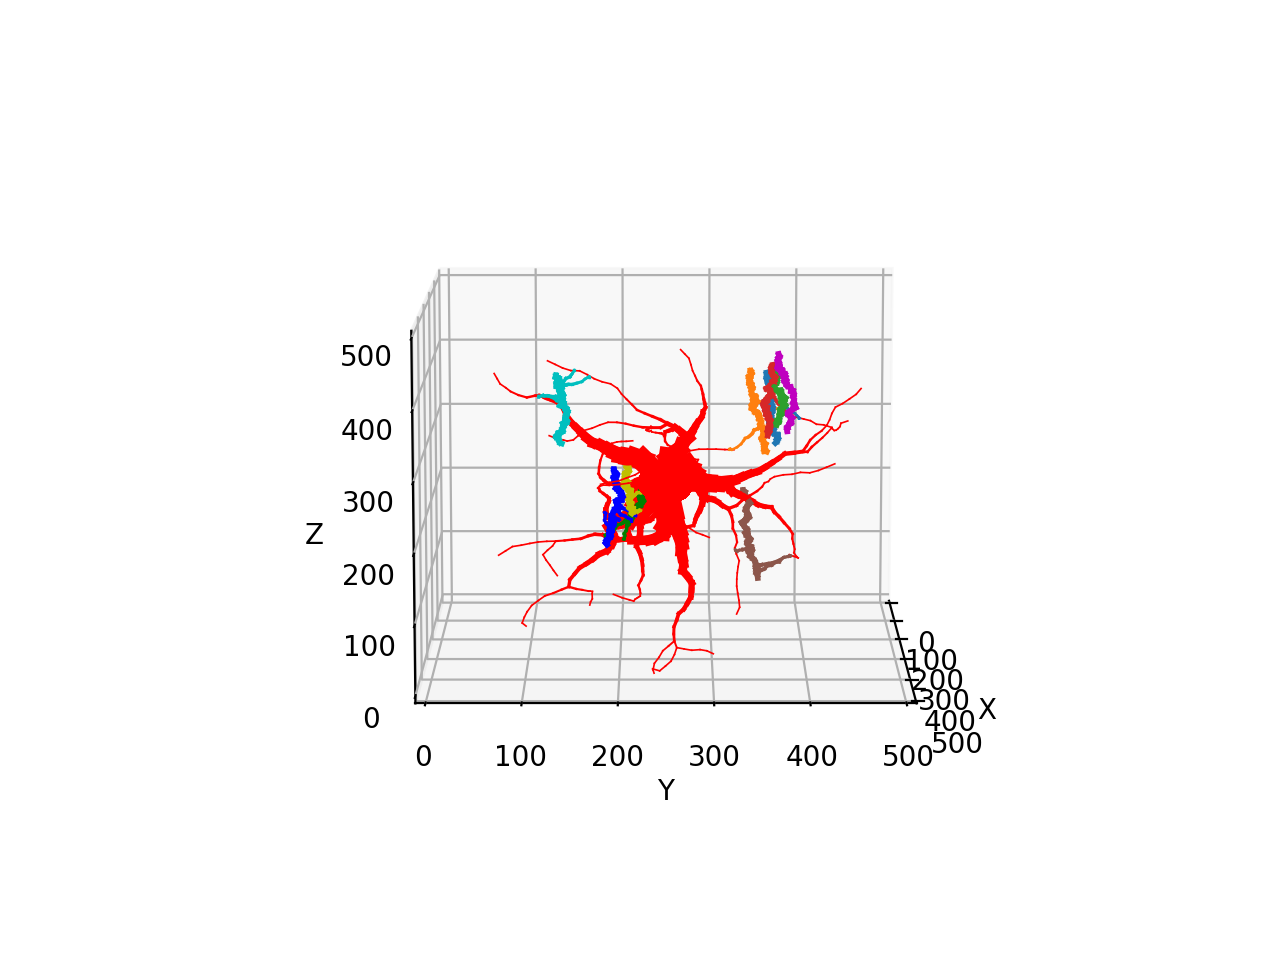

simple_neuron_1_ has 501 fronts with 15 synapses
branch0  has 1 synapses
branch1  has 1 synapses
branch2  has 5 synapses
branch3  has 3 synapses
branch4  has 3 synapses
branch5  has 1 synapses
branch6  has 0 synapses
branch7  has 1 synapses


In [2]:
%matplotlib notebook 

from neurodevsim.simulator import *
import numpy as np

# The postsynaptic neuron
class SimpleNeuronFront(SynFront):
    
    def manage_front(self,constellation):
        if self.swc_type == 1: # this is the soma
            if constellation.cycle == 1: # make dendrite roots
                points = self.unit_branching_sample(16)  # generate vectors
                num_dend = 0 # count number of dendrites
                for p in points: # make 8 dendrites
                    branch = "branch" + str(num_dend)
                    new_pos = self.orig + p * (10. + self.radius) # compute position of dendrite end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=4.,swc_type=3,branch_name=branch) # make a new front
                        num_dend += 1
                        if num_dend == 8: # enough dendrites made
                            # make soma stop growing -> but remains active
                            self.clear_growing() 
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                print ("Warning: less than 8 dendrites made for",self.get_neuron_name(constellation),num_dend)
                # disable soma till cycle 90
                self.disable(constellation,till_cycle=90)
            elif constellation.cycle == 90: # report # synapses on last cycle
                # get total number
                neuron = self.get_neuron(constellation)
                print (self.get_neuron_name(constellation),"has",neuron.num_fronts,"fronts with",neuron.num_synapses,"synapses")
                # get branch specific number
                children = self.get_children(constellation)
                for child in children:
                    syns = child.get_branch_synapses(constellation) # get list of all synapses on this branch
                    print (child.get_branch_name()," has",len(syns),"synapses")
        else:
            if self.path_length >= 300:
                self.disable(constellation) # terminus: stop growing
                return
            bif_prob = 0.30 / (self.order*3)
            if self.order > 4 :
                bif_prob = 0.03
            if np.random.random() > bif_prob: # continue a front
                # taper radius
                rad = self.taper(0.9)
                count = 0 # counts number of add_child trials
                while count < 10:
                    # random component along current heading
                    extension = self.unit_heading_sample(width=20)
                    new_pos = self.end + extension * 10. # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        # make front inactive: stops growing -> will not call this method again
                        self.disable(constellation)
                        return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
                if (constellation.cycle - self.birth) > 2: # this was second failed attempt:
                    self.disable(constellation) # stop trying
            else: # branch a front: generate two child fronts, or terminate
                points = self.unit_branching_sample(5) # generate more points than needed
                rad = self.taper(0.7) # strongly taper radius
                num_dend = 0 # count number of dendrite branches
                for p in points: # make 2 branches
                    new_pos = self.end + p * 10.  # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        num_dend += 1
                        if num_dend == 2: # enough dendrites made
                            # make front inactive: stops growing -> will not call this method again
                            self.disable(constellation)
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                if self.num_children > 0: # single child made -> make front inactive
                    self.disable(constellation)

# Axons growing from left to right and trying to make synapses
class AxonFront(SynFront):
    # extra attributes initalized to False and 0, updated in manage_front
    _fields_ = Front._fields_ + [('goalID', ID),('next_branch',c_short)]
    # status1 is used to flag fronts on the main branch of the axon

    # Main branch grows towards left, side branches grow towards a synapse site
    def manage_front(self,constellation):
        if constellation.cycle == 1: # first axon, main not initialized
            self.set_status1() # mark as main branch
        if self.is_status1(): # continuation of main branch growing leftward
            count = 0 # counts number of add_child trials
            new_front = None
            while count < 10:
                # random component along current heading
                extension = Point(6.,0.,0.) + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos) # make a new front
                    # self stays active in case of branching
                    new_front.set_status1() # mark as main branch
                    new_front.next_branch = max(0, self.next_branch - 1)
                    break # made a front
                except (CollisionError, GridCompetitionError, InsideParentError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
                except (VolumeError):
                    # growing outside of volume -> stop
                    self.disable(constellation)
                    return # completed this call
            if not new_front: # add_child failed
                self.disable(constellation)
                return # completed this call
           # check for nearby fronts
            targets = self.get_fronts(constellation,what='name',name="simple_neuron",max_distance=50.)
            no_branch = True
            for t in targets: # list of (front,distance), ordered by increasing distance
                goal = t[0]
                #print (self.get_neuron_name(constellation),"testing",front)
                if goal.swc_type == 1: # do not synapse on soma
                    continue
                # check whether target front already has a synapse
                if goal.has_synapse():
                    continue
                distance = t[1]
                if distance < 1.: # close enough for a new synapse without branching
                    #print ("cycle",constellation.cycle,":",self.get_neuron_name(constellation),"makes a synapse on",goal.get_branch_name())
                    try:
                        self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                        self.disable(constellation) # no further growth of main
                        return # done, no branching
                    except (SynapseError) as error:
                        print (error)
                elif self.next_branch == 0: # make a branch
                    self.goalID = goal.get_id()
                    new_front.next_branch = 5
                    rad = self.taper(0.7)
                    no_branch = False
                    break
            if no_branch:
                self.disable(constellation) # no further growth of main
                return # done, no branching
        else: # continuation of a branch
            goal = constellation.front_by_id(self.goalID)
            if goal.has_synapse(): # goal has been taken by other branch
                # start retraction of the branch
                parent = self.get_parent(constellation)
                if not parent.is_status1(): # branch front 
                    parent.enable(constellation) # make active so that it retracts also
                self.retract(constellation)
                return
            rad = self.taper(0.95)
        # grow or continue a side branch (can be initiation of first side front from main)
        direction = goal.surface_point_to(self.end) - self.end
        n_direction = direction.norm()
        distance = direction.length()
        if distance < 1.: # close enough for a new synapse
            #print ("cycle",constellation.cycle,":",self.get_neuron_name(constellation),"makes a synapse on",goal.get_branch_name())
            try:
                self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
            except (SynapseError) as error:
                print (error)
            self.disable(constellation) # terminate growth of this axon (main) branch
            return
        else: # grow nearer towards front
            count = 0 # counts number of add_child trials
            while count < 100:
                if distance < 6.: # grow very close to surface of front
                    extension = n_direction * ((distance - 1.) * 0.9) + unit_sample_on_sphere()
                else: # grow front in direction of goal with some noise
                    extension = n_direction * 5. + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                    new_front.goalID = self.goalID
                    self.disable(constellation) # terminate growth of this axon (main) branch 
                    return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/count_synapses.db"
    sim_volume = [[0., 0., 0.], [500., 500., 500.]]
    neuron_types = [SimpleNeuronFront,AxonFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,max_synapse=400,verbose=0,plot=True,soma_black=False,elev=10,azim=0)


    # make simple neuron
    admin.add_neurons(SimpleNeuronFront,"simple_neuron",1,[[300.0,250.0,250.0],[300.,250.,250.]],30.)

    # make 10 axons: these grow 'from outside' into the volume
    admin.add_neurons(AxonFront,"axon",10,[[1,100,100],[1,400,400]],1.,axon=[5.0,0.,0.])
        
    # run the simulation
    admin.simulation_loop(90)

    # clean up
    admin.destruction()

## Retract_few_synapses
Same as previous example but now branches that have only a few synapses are retracted.  Only *SimpleNeuronFront* has changed.

<IPython.core.display.Javascript object>


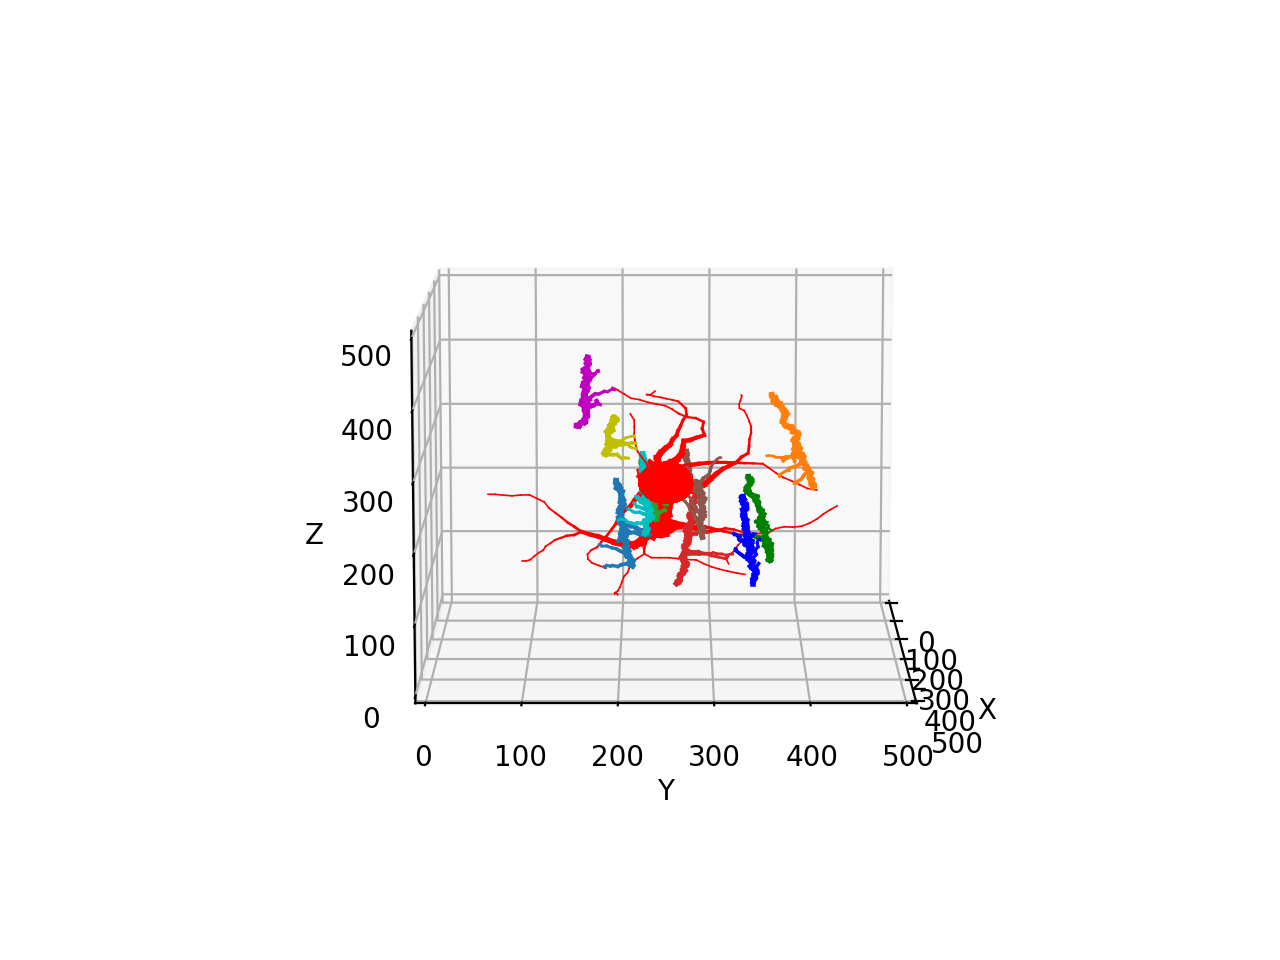

retract_neuron_1_ has 573 fronts with 39 synapses
branch0  has 3 synapses and is retracted
branch1  has 1 synapses and is retracted
branch2  has 12 synapses and stays
branch3  has 0 synapses and is retracted
branch4  has 13 synapses and stays
branch5  has 2 synapses and is retracted
branch6  has 5 synapses and stays
branch7  has 3 synapses and is retracted
retract_neuron_1_ has 271 fronts with 30 synapses


In [3]:
%matplotlib notebook 

from neurodevsim.simulator import *
import numpy as np

# The postsynaptic neuron
class SimpleNeuronFront(SynFront):
    
    def manage_front(self,constellation):
        if self.swc_type == 1: # this is the soma
            if constellation.cycle == 1: # make dendrite roots
                points = self.unit_branching_sample(16)  # generate vectors
                num_dend = 0 # count number of dendrites
                for p in points: # make 8 dendrites
                    branch = "branch" + str(num_dend)
                    new_pos = self.orig + p * (10. + self.radius) # compute position of dendrite end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=4.,swc_type=3,branch_name=branch) # make a new front
                        num_dend += 1
                        if num_dend == 8: # enough dendrites made
                            # make soma stop growing -> but remains active
                            self.disable(constellation,till_cycle=90) 
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                print ("Warning: less than 8 dendrites made for",self.get_neuron_name(constellation),num_dend)
                # disable soma till cycle 90
                self.disable(constellation,till_cycle=90)
            elif constellation.cycle == 90: # delete branches with few synapses on before last cycle
                # print total number before retractions
                neuron = self.get_neuron(constellation)
                children = self.get_children(constellation)
                print (self.get_neuron_name(constellation),"has",neuron.num_fronts,"fronts with",neuron.num_synapses,"synapses")
                for child in children:
                    syns = child.get_branch_synapses(constellation) # get list of all synapses on this branch
                    num_syns = len(syns)
                    if num_syns < 5:
                        print (child.get_branch_name()," has",len(syns),"synapses and is retracted")
                        self.retract_branch(constellation,child)
                    else:
                        print (child.get_branch_name()," has",len(syns),"synapses and stays")
            else: # cycle 91
                # print total number after retractions
                neuron = self.get_neuron(constellation)
                print (self.get_neuron_name(constellation),"has",neuron.num_fronts,"fronts with",neuron.num_synapses,"synapses")
        else:
            if self.path_length >= 300:
                self.disable(constellation) # terminus: stop growing
                return
            bif_prob = 0.30 / (self.order*3)
            if self.order > 4 :
                bif_prob = 0.03
            if np.random.random() > bif_prob: # continue a front
                # taper radius
                rad = self.taper(0.9)
                count = 0 # counts number of add_child trials
                while count < 10:
                    # random component along current heading
                    extension = self.unit_heading_sample(width=20)
                    new_pos = self.end + extension * 10. # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        # make front inactive: stops growing -> will not call this method again
                        self.disable(constellation)
                        return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
                if (constellation.cycle - self.birth) > 2: # this was second failed attempt:
                    self.disable(constellation) # stop trying
            else: # branch a front: generate two child fronts, or terminate
                points = self.unit_branching_sample(5) # generate more points than needed
                rad = self.taper(0.7) # strongly taper radius
                num_dend = 0 # count number of dendrite branches
                for p in points: # make 2 branches
                    new_pos = self.end + p * 10.  # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        num_dend += 1
                        if num_dend == 2: # enough dendrites made
                            # make front inactive: stops growing -> will not call this method again
                            self.disable(constellation)
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                if self.num_children > 0: # single child made -> make front inactive
                    self.disable(constellation)

# Axons growing from left to right and trying to make synapses
class AxonFront(SynFront):
    # extra attributes initalized to False and 0, updated in manage_front
    _fields_ = Front._fields_ + [('goalID', ID),('next_branch',c_short)]
    # status1 is used to flag fronts on the main branch of the axon

    # Main branch grows towards left, side branches grow towards a synapse site
    def manage_front(self,constellation):
        if constellation.cycle == 1: # first axon, main not initialized
            self.set_status1() # mark as main branch
        if self.is_status1(): # continuation of main branch growing leftward
            count = 0 # counts number of add_child trials
            new_front = None
            while count < 10:
                # random component along current heading
                extension = Point(6.,0.,0.) + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos) # make a new front
                    # self stays active in case of branching
                    new_front.set_status1() # mark as main branch
                    new_front.next_branch = max(0, self.next_branch - 1)
                    break # made a front
                except (CollisionError, GridCompetitionError, InsideParentError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
                except (VolumeError):
                    # growing outside of volume -> stop
                    self.disable(constellation)
                    return # completed this call
            if not new_front: # add_child failed
                self.disable(constellation)
                return # completed this call
           # check for nearby fronts
            targets = self.get_fronts(constellation,what='name',name="retract_neuron",max_distance=50.)
            no_branch = True
            for t in targets: # list of (front,distance), ordered by increasing distance
                goal = t[0]
                if goal.swc_type == 1: # do not synapse on soma
                    continue
                # check whether target front already has a synapse
                if goal.has_synapse():
                    continue
                distance = t[1]
                if distance < 1.: # close enough for a new synapse without branching
                    try:
                        self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                        self.disable(constellation) # no further growth of main
                        return # done, no branching
                    except (SynapseError) as error:
                        print (error)
                elif self.next_branch == 0: # make a branch
                    self.goalID = goal.get_id()
                    new_front.next_branch = 5
                    rad = self.taper(0.7)
                    no_branch = False
                    break
            if no_branch:
                self.disable(constellation) # no further growth of main
                return # done, no branching
        else: # continuation of a branch
            goal = constellation.front_by_id(self.goalID)
            if goal.has_synapse(): # goal has been taken by other branch
                # start retraction of the branch
                parent = self.get_parent(constellation)
                if not parent.is_status1(): # branch front 
                    parent.enable(constellation) # make active so that it retracts also
                self.retract(constellation)
                return
            rad = self.taper(0.95)
        # grow or continue a side branch (can be initiation of first side front from main)
        direction = goal.surface_point_to(self.end) - self.end
        n_direction = direction.norm()
        distance = direction.length()
        if distance < 1.: # close enough for a new synapse
            #print ("cycle",constellation.cycle,":",self.get_neuron_name(constellation),"makes a synapse on",goal.get_branch_name())
            try:
                self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
            except (SynapseError) as error:
                print (error)
            self.disable(constellation) # terminate growth of this axon (main) branch
            return
        else: # grow nearer towards front
            count = 0 # counts number of add_child trials
            while count < 100:
                if distance < 6.: # grow very close to surface of front
                    extension = n_direction * ((distance - 1.) * 0.9) + unit_sample_on_sphere()
                else: # grow front in direction of goal with some noise
                    extension = n_direction * 5. + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                    new_front.goalID = self.goalID
                    self.disable(constellation) # terminate growth of this axon (main) branch
                    return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/retract_synapses.db"
    sim_volume = [[0., 0., 0.], [500., 500., 500.]]
    neuron_types = [SimpleNeuronFront,AxonFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,max_synapse=400,verbose=0,plot=True,soma_black=False,elev=10,azim=0)


    # make simple neuron
    admin.add_neurons(SimpleNeuronFront,"retract_neuron",1,[[300.0,250.0,250.0],[300.,250.,250.]],30.)

    # make 10 axons: these grow 'from outside' into the volume
    admin.add_neurons(AxonFront,"axon",10,[[1,100,100],[1,400,400]],1.,axon=[5.0,0.,0.])
        
    # run the simulation
    admin.simulation_loop(91)

    # clean up
    admin.destruction()

## Integrated_variable_input
The *firing_rate* of the axons is randomly varied, resulting in different *syn_input* values for each synapse. The varying *syn_input* is integrated over cycles in the additional attribute *signal* in *SimpleNeuronFront*.  Both *SimpleNeuronFront* and *AxonFront* codes are changed.  
This script produces a lot of printing output that does not look nice in a notebook, printing looks better when run in a terminal window.  
An elaboration of this model could subdivide the axons in groups with different mean *firing_rate* so that some are consistently very active and others not.

<IPython.core.display.Javascript object>


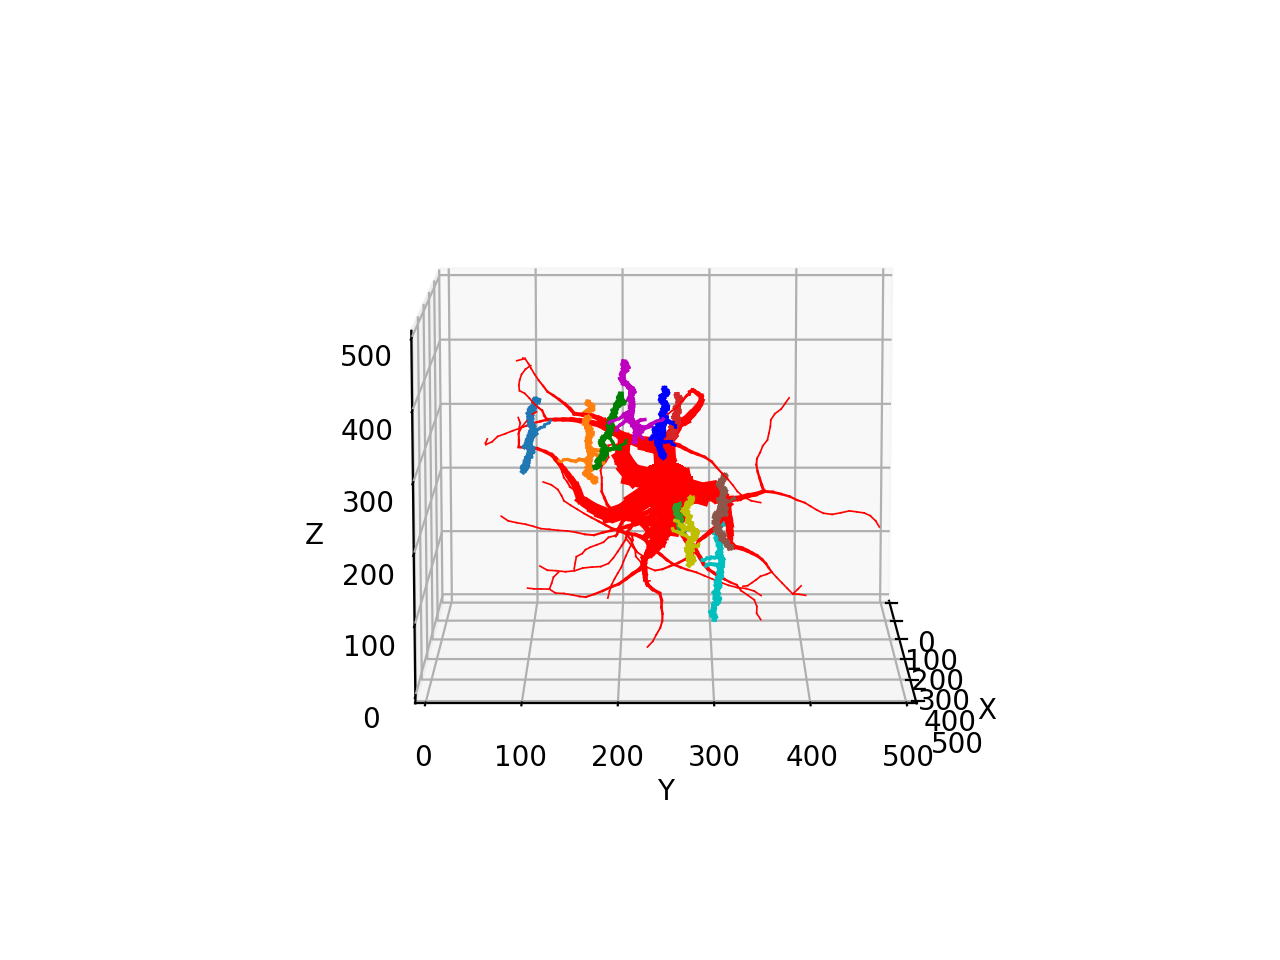

axonaxonaxon   423   initial firing rate: 3.03initial firing rate: 3.68initial firing rate: 9.08


axonaxonaxonaxon    5867    initial firing rate: 3.97initial firing rate: 5.98initial firing rate: 9.45initial firing rate: 7.27



axonaxonaxon   11109   initial firing rate: 8.80initial firing rate: 7.76initial firing rate: 5.51


18 axon 8 changes firing rate from: 9.45  to: 7.79
21 axon 4  changes firing rate from: 3.68 to: 6.74
28 axon 5 changes firing rate from: 3.97  to: 6.75
36 axon 2 8103 add_child failed
cycle 39 : axon_6_ makes a synapse on 4036
cycle 43 : axon_10_ makes a synapse on 8024
cycle  44 : axon_4_makes a synapse on 16060
cycle 45 : axon_2_ makes a synapse on 16136
cycle  46: axon_4_ makes a synapse on 8046
47 axon 9 changes firing rate from: 5.51  to: 3.71
48
 axon 2 12139 add_child failedcycle 50 : axon_1_ makes a synapse on 12016
cycle 52 : axon_8_ makes a synapse on 4067
cycle 53 : axon_6_ makes a synapse on 16026
cycle 53 : axon_7_ makes a synapse on 12014
cycle 

In [4]:
%matplotlib notebook 

from neurodevsim.simulator import *
import numpy as np

# Control parameters
MAX_FR = 10. # maximum firing_rate, firing_rate will be in range 0. - MAX_FR
NEW_FR = 0.01 # probability that firing_rate will change on this cycle
SIGNAL_DECAY = 20. # rate in cycles at which signal decays back to zero.

# The postsynaptic neuron
class SimpleNeuronFront(SynFront):
    # extraintegrates syn_input over time
    _fields_ = SynFront._fields_ + [('signal', c_double)]
    
    def manage_front(self,constellation):
        if self.swc_type == 1: # this is the soma
            points = self.unit_branching_sample(16)  # generate vectors
            num_dend = 0 # count number of dendrites
            for p in points: # make 8 dendrites
                new_pos = self.orig + p * (10. + self.radius) # compute position of dendrite end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=4.,swc_type=3) # make a new front
                    num_dend += 1
                    if num_dend == 8: # enough dendrites made
                        # make soma inactive: stops growing -> will not call this method again
                        self.disable(constellation)
                        return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            print ("Warning: less than 8 dendrites made for",self.get_neuron_name(constellation),num_dend)
            # make soma inactive: stops growing -> will not call this method again
            self.disable(constellation)
        elif self.num_children == 0: # grow if no children present
            if self.path_length >= 300:
                if self.is_postsynaptic(): # do not disable
                    self.clear_growing() # but stop growing
                else:
                    self.disable(constellation) # terminus: stop growing
                return
            bif_prob = 0.30 / (self.order*3)
            if self.order > 4 :
                bif_prob = 0.03
            if np.random.random() > bif_prob: # continue a front
                # taper radius
                rad = self.taper(0.9)
                count = 0 # counts number of add_child trials
                while count < 10:
                    # random component along current heading
                    extension = self.unit_heading_sample(width=20)
                    new_pos = self.end + extension * 10. # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        if self.is_postsynaptic(): # do not disable to keep computing syn_input and signal
                            self.clear_growing() # but stop growing
                        else: # make front inactive: stops growing
                            self.disable(constellation)
                        return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
                if (constellation.cycle - self.birth) > 2: # this was second failed attempt:
                    if self.is_postsynaptic(): # do not disable to keep computing syn_input and signal
                        self.clear_growing() # but stop growing
                    else: # make front inactive: stops growing
                        self.disable(constellation)
            else: # branch a front: generate two child fronts, or terminate
                points = self.unit_branching_sample(5) # generate more points than needed
                rad = self.taper(0.7) # strongly taper radius
                num_dend = 0 # count number of dendrite branches
                for p in points: # make 2 branches
                    new_pos = self.end + p * 10.  # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        num_dend += 1
                        if num_dend == 2: # enough dendrites made
                            if self.is_postsynaptic(): # do not disable to keep computing syn_input and signal
                                self.clear_growing() # but stop growing
                            else: # make front inactive: stops growing
                                self.disable(constellation)
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                if self.num_children > 0: # single child made -> make front inactive
                    self.disable(constellation)
        else: # front has a synapse and integrates syn_input each cycle
            self.signal += self.syn_input - (self.signal / SIGNAL_DECAY)
            # print value of signal
            if constellation.cycle == 90: 
                print (constellation.cycle,self._fid," input: {:4.2f}".format(self.syn_input)," signal: {:4.2f}".format(self.signal))

# Axons growing from left to right and trying to make synapses
class AxonFront(SynFront):
    # extra attributes initalized to False and 0, updated in manage_front
    _fields_ = Front._fields_ + [('goalID', ID),('next_branch',c_short)]
    # status1 is used to flag fronts on the main branch of the axon

    # Main branch grows towards left, side branches grow towards a synapse site
    def manage_front(self,constellation):
        if constellation.cycle == 1: # first axon, main not initialized
            self.set_status1() # mark as main branch
            # set initial firing rate
            neuron = self.get_neuron(constellation)
            rate = np.random.random() * MAX_FR
            neuron.set_firing_rate(constellation,rate)
            print ("axon",neuron._neid,"initial firing rate: {:4.2f}".format(rate))
        elif self.num_children > 0: # root of axon that remains active
            if np.random.random() < NEW_FR: # change firing rate
                neuron = self.get_neuron(constellation)
                rate = np.random.random() * MAX_FR
                print (constellation.cycle,"axon",neuron._neid,"changes firing rate from: {:4.2f}".format(neuron.firing_rate)," to: {:4.2f}".format(rate))
                neuron.set_firing_rate(constellation,rate)                
            return # do not grow anymore...
        if self.is_status1(): # continuation of main branch growing leftward
            count = 0 # counts number of add_child trials
            new_front = None
            while count < 10:
                # random component along current heading
                extension = Point(6.,0.,0.) + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos) # make a new front
                    new_front.set_status1() # mark as main branch
                    new_front.next_branch = max(0, self.next_branch - 1)
                    break # made a front
                except (CollisionError, GridCompetitionError, InsideParentError) as error:
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
                except (VolumeError):
                    # growing outside of volume -> stop
                    self.disable(constellation)
                    return # completed this call
            if not new_front: # add_child failed
                print (constellation.cycle,"axon",self._nid,self._fid,"add_child failed")
                self.disable(constellation)
                return # completed this call
            # check for nearby fronts: 
            targets = self.get_fronts(constellation,what='name',name="integrate_neuron",max_distance=50.)
            no_branch = True
            for t in targets: # list of (front,distance), ordered by increasing distance
                goal = t[0]
                #print (self.get_neuron_name(constellation),"testing",front)
                if goal.swc_type == 1: # do not synapse on soma
                    continue
                # check whether target front already has a synapse
                if goal.has_synapse():
                    continue
                distance = t[1]
                if distance < 1.: # close enough for a new synapse without branching
                    print ("cycle",constellation.cycle,":",self.get_neuron_name(constellation),"makes a synapse on",goal._fid,goal._yid)
                    try:
                        self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                        self.disable(constellation) # no further growth of main
                        goal.enable(constellation) # make postsynaptic front active again so that it computes signal
                        return # done, no branching
                    except (SynapseError) as error:
                        print (error)
                    goal.enable(constellation) # make postsynaptic front active again so that it computes signal
                elif self.next_branch == 0: # make a branch
                    self.goalID = goal.get_id()
                    new_front.next_branch = 5
                    rad = self.taper(0.7)
                    no_branch = False
                    break
            if no_branch:
                if self.order > 0: # terminate growth of this axon (main) branch 
                    self.disable(constellation)
                return # done, no branching
        else: # continuation of a branch
            goal = constellation.front_by_id(self.goalID)
            if goal.has_synapse(): # goal has been taken by other branch
                # start retraction of the branch, front by front
                parent = self.get_parent(constellation)
                if not parent.is_status1(): # branch front 
                    parent.enable(constellation) # make active so that it retracts also
                self.retract(constellation)
                return
            rad = self.taper(0.95)
        # grow or continue a side branch (can be initiation of first side front from main)
        direction = goal.surface_point_to(self.end) - self.end
        n_direction = direction.norm()
        distance = direction.length()
        if distance < 1.: # close enough for a new synapse
            print ("cycle",constellation.cycle,":",self.get_neuron_name(constellation),"makes a synapse on",goal._fid)
            try:
                self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
            except (SynapseError) as error:
                print (error)
            if self.order > 0: # terminate growth of this axon (main) branch 
                self.disable(constellation)
            goal.enable(constellation) # make postsynaptic front active again so that it computes signal
            return # done, no branching
        else: # grow nearer towards front
            count = 0 # counts number of add_child trials
            while count < 10:
                if distance < 6.: # grow very close to surface of front
                    extension = n_direction * ((distance - 1.) * 0.9) + unit_sample_on_sphere()
                else: # grow front in direction of goal with some noise
                    extension = n_direction * 5. + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                    new_front.goalID = self.goalID
                    # make front inactive: stops growing -> will not call this method again
                    if self.order > 0: # terminate growth of this axon (main) branch 
                        self.disable(constellation)
                    return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/integrate_synapses.db"
    sim_volume = [[0., 0., 0.], [500., 500., 500.]]
    neuron_types = [SimpleNeuronFront,AxonFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,max_synapse=400,verbose=0,plot=True,soma_black=False,elev=10,azim=0)

    # make simple neuron
    admin.add_neurons(SimpleNeuronFront,"integrate_neuron",1,[[300.0,250.0,250.0],[300.,250.,250.]],30.)

    # make 10 axons: these grow 'from outside' into the volume
    admin.add_neurons(AxonFront,"axon",10,[[1,100,100],[1,400,400]],1.,axon=[5.0,0.,0.])
        
    # run the simulation
    admin.simulation_loop(90)

    # clean up
    admin.destruction()

## Colored_signal
Same as previous model but SimpleNeuron fronts are now color coded for the value of *signal* using optional parameter `color_scheme=3`. All print statements have been removed.

<IPython.core.display.Javascript object>


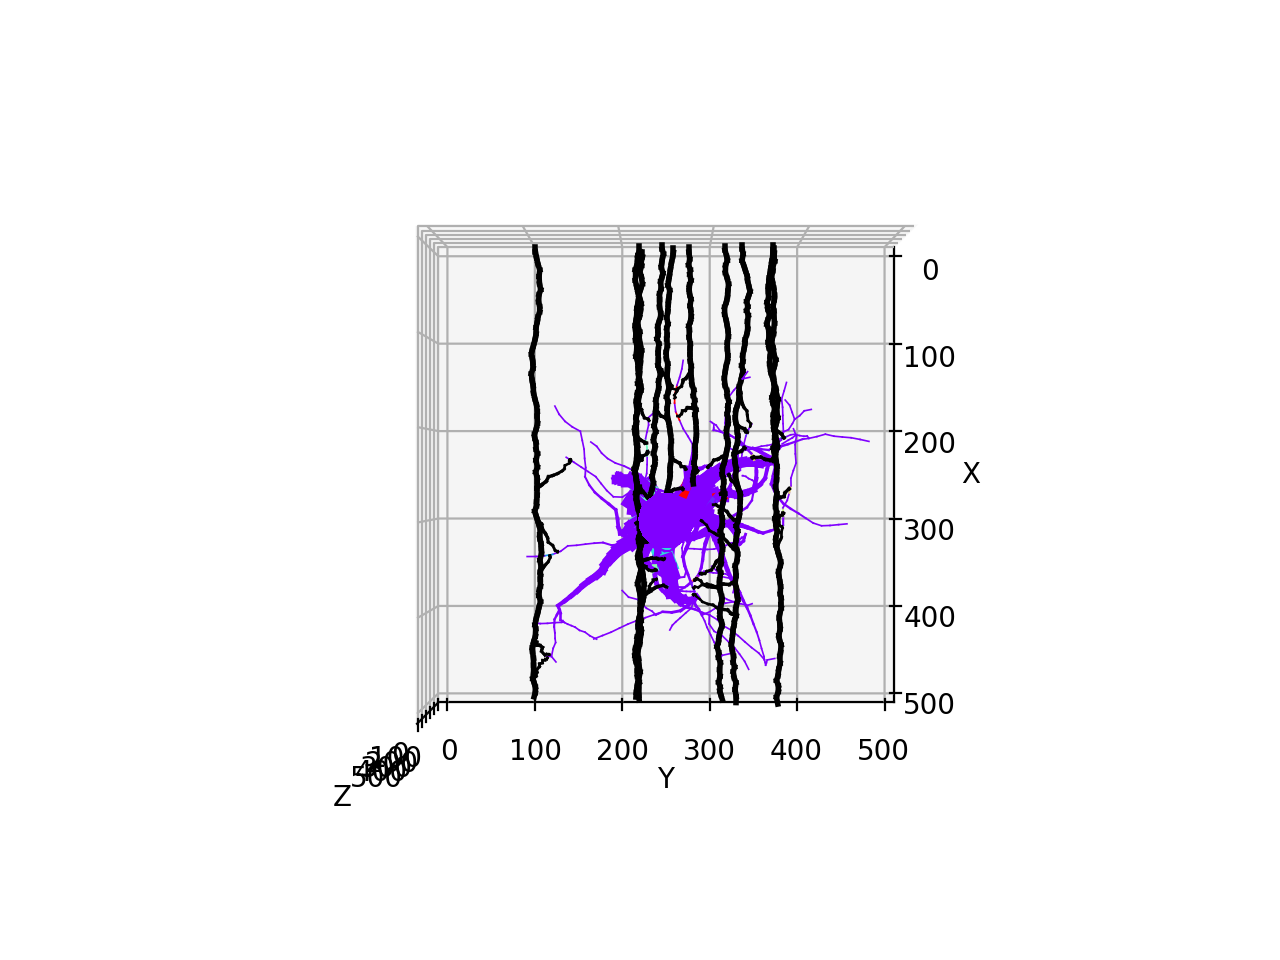

40 axon 2 4130 add_child failed
43 axon 2 4151 add_child failed
46 axon 2 8160 add_child failed
56 axon 2 8189 add_child failed


In [5]:
%matplotlib notebook 

from neurodevsim.simulator import *
import numpy as np

# Control parameters
MAX_FR = 10. # maximum firing_rate, firing_rate will be in range 0. - MAX_FR
NEW_FR = 0.01 # probability that firing_rate will change on this cycle
SIGNAL_DECAY = 20. # rate in cycles at which signal decays back to zero.

# The postsynaptic neuron
class SimpleNeuronFront(SynFront):
    # extraintegrates syn_input over time
    _fields_ = SynFront._fields_ + [('signal', c_double)]
    
    def manage_front(self,constellation):
        if self.swc_type == 1: # this is the soma
            points = self.unit_branching_sample(16)  # generate vectors
            num_dend = 0 # count number of dendrites
            for p in points: # make 8 dendrites
                new_pos = self.orig + p * (10. + self.radius) # compute position of dendrite end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=4.,swc_type=3) # make a new front
                    num_dend += 1
                    if num_dend == 8: # enough dendrites made
                        # make soma inactive: stops growing -> will not call this method again
                        self.disable(constellation)
                        return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            print ("Warning: less than 8 dendrites made for",self.get_neuron_name(constellation),num_dend)
            # make soma inactive: stops growing -> will not call this method again
            self.disable(constellation)
        elif self.num_children == 0: # grow if no children present
            if self.path_length >= 300:
                if self.is_postsynaptic(): # do not disable to keep computing syn_input and signal
                    self.clear_growing() # but stop growing
                else:
                    self.disable(constellation) # terminus: stop growing
                return
            bif_prob = 0.30 / (self.order*3)
            if self.order > 4 :
                bif_prob = 0.03
            if np.random.random() > bif_prob: # continue a front
                # taper radius
                rad = self.taper(0.9)
                count = 0 # counts number of add_child trials
                while count < 10:
                    # random component along current heading
                    extension = self.unit_heading_sample(width=20)
                    new_pos = self.end + extension * 10. # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        if self.is_postsynaptic(): # do not disable to keep computing syn_input and signal
                            self.clear_growing() # but stop growing
                        else: # make front inactive: stops growing
                            self.disable(constellation)
                        return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
                if (constellation.cycle - self.birth) > 2: # this was second failed attempt:
                    if self.is_postsynaptic(): # do not disable to keep computing syn_input and signal
                        self.clear_growing() # but stop growing
                    else: # make front inactive: stops growing
                        self.disable(constellation)
            else: # branch a front: generate two child fronts, or terminate
                points = self.unit_branching_sample(5) # generate more points than needed
                rad = self.taper(0.7) # strongly taper radius
                num_dend = 0 # count number of dendrite branches
                for p in points: # make 2 branches
                    new_pos = self.end + p * 10.  # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        num_dend += 1
                        if num_dend == 2: # enough dendrites made
                            if self.is_postsynaptic(): # do not disable to keep computing syn_input and signal
                                self.clear_growing() # but stop growing
                            else: # make front inactive: stops growing
                                self.disable(constellation)
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                if self.num_children > 0: # single child made -> make front inactive
                    self.disable(constellation)
        else: # front has a synapse and integrates syn_input each cycle
            self.signal += self.syn_input - (self.signal / SIGNAL_DECAY)

# Axons growing from left to right and trying to make synapses
class AxonFront(SynFront):
    # extra attributes initalized to False and 0, updated in manage_front
    _fields_ = Front._fields_ + [('goalID', ID),('next_branch',c_short)]
    # status1 is used to flag fronts on the main branch of the axon

    # Main branch grows towards left, side branches grow towards a synapse site
    def manage_front(self,constellation):
        if constellation.cycle == 1: # first axon, main not initialized
            self.set_status1() # mark as main branch
            # set initial firing rate
            neuron = self.get_neuron(constellation)
            rate = np.random.random() * MAX_FR
            neuron.set_firing_rate(constellation,rate)
        elif self.num_children > 0: # root of axon that remains active
            if np.random.random() < NEW_FR: # change firing rate
                neuron = self.get_neuron(constellation)
                rate = np.random.random() * MAX_FR
                neuron.set_firing_rate(constellation,rate)                
            return # do not grow anymore...
        if self.is_status1(): # continuation of main branch growing leftward
            count = 0 # counts number of add_child trials
            new_front = None
            while count < 10:
                # random component along current heading
                extension = Point(6.,0.,0.) + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos) # make a new front
                    new_front.set_status1() # mark as main branch
                    new_front.next_branch = max(0, self.next_branch - 1)
                    break # made a front
                except (CollisionError, GridCompetitionError, InsideParentError) as error:
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
                except (VolumeError):
                    # growing outside of volume -> stop
                    self.disable(constellation)
                    return # completed this call
            if not new_front: # add_child failed
                print (constellation.cycle,"axon",self._nid,self._fid,"add_child failed")
                self.disable(constellation)
                return # completed this call
            # check for nearby fronts: 
            targets = self.get_fronts(constellation,what='name',name="integrate_neuron",max_distance=50.)
            no_branch = True
            for t in targets: # list of (front,distance), ordered by increasing distance
                goal = t[0]
                #print (self.get_neuron_name(constellation),"testing",front)
                if goal.swc_type == 1: # do not synapse on soma
                    continue
                # check whether target front already has a synapse
                if goal.has_synapse():
                    continue
                distance = t[1]
                if distance < 1.: # close enough for a new synapse without branching
                    print ("cycle",constellation.cycle,":",self.get_neuron_name(constellation),"makes a synapse on",goal._fid,goal._yid)
                    try:
                        self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                        self.disable(constellation) # no further growth of main
                        goal.enable(constellation) # make postsynaptic front active again so that it computes signal
                        return # done, no branching
                    except (SynapseError) as error:
                        print (error)
                    goal.enable(constellation) # make postsynaptic front active again so that it computes signal
                elif self.next_branch == 0: # make a branch
                    self.goalID = goal.get_id()
                    new_front.next_branch = 5
                    rad = self.taper(0.7)
                    no_branch = False
                    break
            if no_branch:
                if self.order > 0: # terminate growth of this axon (main) branch 
                    self.disable(constellation)
                return # done, no branching
        else: # continuation of a branch
            goal = constellation.front_by_id(self.goalID)
            if goal.has_synapse(): # goal has been taken by other branch
                # start retraction of the branch, front by front
                parent = self.get_parent(constellation)
                if not parent.is_status1(): # branch front 
                    parent.enable(constellation) # make active so that it retracts also
                self.retract(constellation)
                return
            rad = self.taper(0.95)
        # grow or continue a side branch (can be initiation of first side front from main)
        direction = goal.surface_point_to(self.end) - self.end
        n_direction = direction.norm()
        distance = direction.length()
        if distance < 1.: # close enough for a new synapse
            try:
                self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
            except (SynapseError) as error:
                print (error)
            if self.order > 0: # terminate growth of this axon (main) branch 
                self.disable(constellation)
            goal.enable(constellation) # make postsynaptic front active again so that it computes signal
            return # done, no branching
        else: # grow nearer towards front
            count = 0 # counts number of add_child trials
            while count < 10:
                if distance < 6.: # grow very close to surface of front
                    extension = n_direction * ((distance - 1.) * 0.9) + unit_sample_on_sphere()
                else: # grow front in direction of goal with some noise
                    extension = n_direction * 5. + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                    new_front.goalID = self.goalID
                    # make front inactive: stops growing -> will not call this method again
                    if self.order > 0: # terminate growth of this axon (main) branch 
                        self.disable(constellation)
                    return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/integrate_synapses.db"
    sim_volume = [[0., 0., 0.], [500., 500., 500.]]
    neuron_types = [SimpleNeuronFront,AxonFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,max_synapse=400,verbose=0,plot=True,color_scheme=3,color_data=["signal",0.,100.],elev=90,azim=0)

    # make simple neuron
    admin.add_neurons(SimpleNeuronFront,"integrate_neuron",1,[[300.0,250.0,250.0],[300.,250.,250.]],30.)

    # make 10 axons: these grow 'from outside' into the volume
    admin.add_neurons(AxonFront,"axon",10,[[1,100,100],[1,400,400]],1.,axon=[5.0,0.,0.])
        
    # run the simulation
    admin.simulation_loop(90)

    # clean up
    admin.destruction()

## Retract_low_input
Same as previous example but now branches that have a low integrated synaptic input at cycle 90 are retracted.  This is computed in a way similar to how branches were retracted in [Retract_few_synapses](#Retract_few_synapses), but now the signal from all postsynaptic fronts in a dendrite is summed. Only code of *SimpleNeuronFront* has changed, but printing statements have been removed from both.

<IPython.core.display.Javascript object>


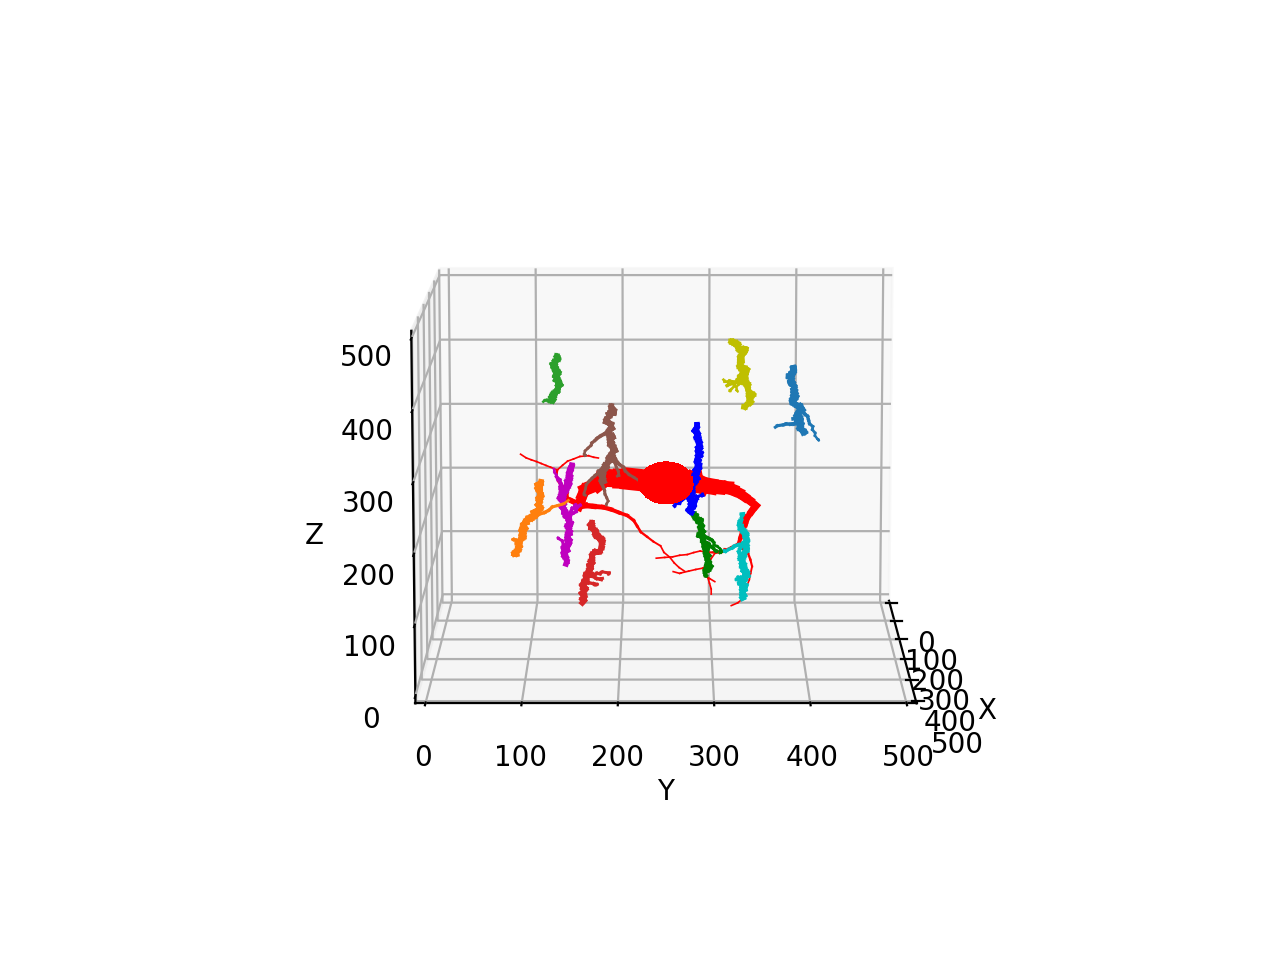

retract_signal_neuron_1_ has 464 fronts with 29 synapses, mean summed input per dendrite: 237.70
branch0  summed input of  0.00 and is retracted
branch1  summed input of 59.07 and is retracted
branch2  summed input of 80.67 and is retracted
branch3  summed input of 810.57 and stays
branch4  summed input of 471.59 and stays
branch5  summed input of 219.94 and is retracted
branch6  summed input of 144.65 and is retracted
branch7  summed input of 115.13 and is retracted
retract_signal_neuron_1_ has 114 fronts with 13 synapses


In [6]:
%matplotlib notebook 

from neurodevsim.simulator import *
import numpy as np

# Control parameters
MAX_FR = 10. # maximum firing_rate, firing_rate will be in range 0. - MAX_FR
NEW_FR = 0.01 # probability that firing_rate will change on this cycle
SIGNAL_DECAY = 20. # rate in cycles at which signal decays back to zero.

# The postsynaptic neuron
class SimpleNeuronFront(SynFront):
    # extraintegrates syn_input over time
    _fields_ = SynFront._fields_ + [('signal', c_double)]
    
    def manage_front(self,constellation):
        if self.swc_type == 1: # this is the soma
            if constellation.cycle == 1: # make dendrite roots
                points = self.unit_branching_sample(16)  # generate vectors
                num_dend = 0 # count number of dendrites
                for p in points: # make 8 dendrites
                    branch = "branch" + str(num_dend)
                    new_pos = self.orig + p * (10. + self.radius) # compute position of dendrite end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=4.,swc_type=3,branch_name=branch) # make a new front
                        num_dend += 1
                        if num_dend == 8: # enough dendrites made
                            # make soma stop growing -> but remains active
                            self.disable(constellation,till_cycle=90) 
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                print ("Warning: less than 8 dendrites made for",self.get_neuron_name(constellation),num_dend)
                # disable soma till cycle 90
                self.disable(constellation,till_cycle=90)
            elif constellation.cycle == 90: # delete branches with low total input
                total_input = [0.] * self.num_children # store summed signal from each synapse in a dendrite
                # print total number before retractions
                neuron = self.get_neuron(constellation)
                children = self.get_children(constellation)
                nd = 0 # index of current dendrite
                sum_tot = 0. # sum all dendrite totals to compute the mean
                # compute total signal for each dendrite
                for child in children:
                    syns = child.get_branch_synapses(constellation) # get list of all synapses on this branch
                    for syn in syns: # get signal and add to total
                        den_front = constellation.front_by_id(syn.post_syn)
                        total_input[nd] += den_front.signal
                    sum_tot += total_input[nd]
                    nd += 1
                mean_tot = sum_tot / self.num_children
                print (self.get_neuron_name(constellation),"has",neuron.num_fronts,"fronts with",neuron.num_synapses,"synapses, mean summed input per dendrite: {:5.2f}".format(mean_tot))
                # retract dendrites with less input than mean
                nd = 0
                for child in children:
                    if total_input[nd] <= mean_tot:
                        print (child.get_branch_name()," summed input of {:5.2f}".format(total_input[nd]),"and is retracted")
                        self.retract_branch(constellation,child)
                    else:
                        print (child.get_branch_name()," summed input of {:5.2f}".format(total_input[nd]),"and stays")
                    nd += 1
            else: # cycle 91
                # print total number after retractions
                neuron = self.get_neuron(constellation)
                print (self.get_neuron_name(constellation),"has",neuron.num_fronts,"fronts with",neuron.num_synapses,"synapses")
        elif self.num_children == 0: # grow if no children present
            if self.path_length >= 300:
                if self.is_postsynaptic(): # do not disable to keep computing syn_input and signal
                    self.clear_growing() # but stop growing
                else:
                    self.disable(constellation) # terminus: stop growing
                return
            bif_prob = 0.30 / (self.order*3)
            if self.order > 4 :
                bif_prob = 0.03
            if np.random.random() > bif_prob: # continue a front
                # taper radius
                rad = self.taper(0.9)
                count = 0 # counts number of add_child trials
                while count < 10:
                    # random component along current heading
                    extension = self.unit_heading_sample(width=20)
                    new_pos = self.end + extension * 10. # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        if self.is_postsynaptic(): # do not disable to keep computing syn_input and signal
                            self.clear_growing() # but stop growing
                        else: # make front inactive: stops growing
                            self.disable(constellation)
                        return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
                if (constellation.cycle - self.birth) > 2: # this was second failed attempt:
                    if self.is_postsynaptic(): # do not disable to keep computing syn_input and signal
                        self.clear_growing() # but stop growing
                    else: # make front inactive: stops growing
                        self.disable(constellation)
            else: # branch a front: generate two child fronts, or terminate
                points = self.unit_branching_sample(5) # generate more points than needed
                rad = self.taper(0.7) # strongly taper radius
                num_dend = 0 # count number of dendrite branches
                for p in points: # make 2 branches
                    new_pos = self.end + p * 10.  # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        num_dend += 1
                        if num_dend == 2: # enough dendrites made
                            if self.is_postsynaptic(): # do not disable to keep computing syn_input and signal
                                self.clear_growing() # but stop growing
                            else: # make front inactive: stops growing
                                self.disable(constellation)
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                if self.num_children > 0: # single child made -> make front inactive
                    self.disable(constellation)
        else: # front has a synapse and integrates syn_input each cycle
            self.signal += self.syn_input - (self.signal / SIGNAL_DECAY)

# Axons growing from left to right and trying to make synapses
class AxonFront(SynFront):
    # extra attributes initalized to False and 0, updated in manage_front
    _fields_ = Front._fields_ + [('goalID', ID),('next_branch',c_short)]
    # status1 is used to flag fronts on the main branch of the axon

    # Main branch grows towards left, side branches grow towards a synapse site
    def manage_front(self,constellation):
        if constellation.cycle == 1: # first axon, main not initialized
            self.set_status1() # mark as main branch
            # set initial firing rate
            neuron = self.get_neuron(constellation)
            rate = np.random.random() * MAX_FR
            neuron.set_firing_rate(constellation,rate)
        elif self.num_children > 0: # root of axon that remains active
            if np.random.random() < NEW_FR: # change firing rate
                neuron = self.get_neuron(constellation)
                rate = np.random.random() * MAX_FR
                neuron.set_firing_rate(constellation,rate)                
            return # do not grow anymore...
        if self.is_status1(): # continuation of main branch growing leftward
            count = 0 # counts number of add_child trials
            new_front = None
            while count < 10:
                # random component along current heading
                extension = Point(6.,0.,0.) + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos) # make a new front
                    new_front.set_status1() # mark as main branch
                    new_front.next_branch = max(0, self.next_branch - 1)
                    break # made a front
                except (CollisionError, GridCompetitionError, InsideParentError) as error:
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
                except (VolumeError):
                    # growing outside of volume -> stop
                    self.disable(constellation)
                    return # completed this call
            if not new_front: # add_child failed
                self.disable(constellation)
                return # completed this call
            # check for nearby fronts: 
            targets = self.get_fronts(constellation,what='name',name="retract_signal_neuron",max_distance=50.)
            no_branch = True
            for t in targets: # list of (front,distance), ordered by increasing distance
                goal = t[0]
                #print (self.get_neuron_name(constellation),"testing",front)
                if goal.swc_type == 1: # do not synapse on soma
                    continue
                # check whether target front already has a synapse
                if goal.has_synapse():
                    continue
                distance = t[1]
                if distance < 1.: # close enough for a new synapse without branching
                    try:
                        self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                        self.disable(constellation) # no further growth of main
                        goal.enable(constellation) # make postsynaptic front active again so that it computes signal
                        return # done, no branching
                    except (SynapseError) as error:
                        print (error)
                    goal.enable(constellation) # make postsynaptic front active again so that it computes signal
                elif self.next_branch == 0: # make a branch
                    self.goalID = goal.get_id()
                    new_front.next_branch = 5
                    rad = self.taper(0.7)
                    no_branch = False
                    break
            if no_branch:
                if self.order > 0: # terminate growth of this axon (main) branch 
                    self.disable(constellation)
                return # done, no branching
        else: # continuation of a branch
            goal = constellation.front_by_id(self.goalID)
            if goal.has_synapse(): # goal has been taken by other branch
                # start retraction of the branch, front by front
                parent = self.get_parent(constellation)
                if not parent.is_status1(): # branch front 
                    parent.enable(constellation) # make active so that it retracts also
                self.retract(constellation)
                return
            rad = self.taper(0.95)
        # grow or continue a side branch (can be initiation of first side front from main)
        direction = goal.surface_point_to(self.end) - self.end
        n_direction = direction.norm()
        distance = direction.length()
        if distance < 1.: # close enough for a new synapse
            try:
                self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
            except (SynapseError) as error:
                print (error)
            if self.order > 0: # terminate growth of this axon (main) branch 
                self.disable(constellation)
            goal.enable(constellation) # make postsynaptic front active again so that it computes signal
            return # done, no branching
        else: # grow nearer towards front
            count = 0 # counts number of add_child trials
            while count < 10:
                if distance < 6.: # grow very close to surface of front
                    extension = n_direction * ((distance - 1.) * 0.9) + unit_sample_on_sphere()
                else: # grow front in direction of goal with some noise
                    extension = n_direction * 5. + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                    new_front.goalID = self.goalID
                    # make front inactive: stops growing -> will not call this method again
                    if self.order > 0: # terminate growth of this axon (main) branch 
                        self.disable(constellation)
                    return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/retract_signal_synapses.db"
    sim_volume = [[0., 0., 0.], [500., 500., 500.]]
    neuron_types = [SimpleNeuronFront,AxonFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,max_synapse=400,verbose=0,plot=True,soma_black=False,elev=10,azim=0)

    # make simple neuron
    admin.add_neurons(SimpleNeuronFront,"retract_signal_neuron",1,[[300.0,250.0,250.0],[300.,250.,250.]],30.)

    # make 10 axons: these grow 'from outside' into the volume
    admin.add_neurons(AxonFront,"axon",10,[[1,100,100],[1,400,400]],1.,axon=[5.0,0.,0.])
        
    # run the simulation
    admin.simulation_loop(91)

    # clean up
    admin.destruction()